In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.functional as F
import pytorch_lightning as pl
import numpy as np
from mpl_toolkits import mplot3d
import pickle
from torchdyn.datasets import *
from torchdyn.utils import *
from spherical import SphericalTensor
import e3nn

Below is just showing the quickstart to torchdyn

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:1764: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  rank_zero_warn(

  | Name  | Type      | Params
------------------------------------
0 | model | NeuralODE | 82    
------------------------------------
82        Trainable params
0         Non-trainable params
82        Total params
0.000     Total estimated model params size (MB)
c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (tr

Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument mat1 in method wrapper_addmm)

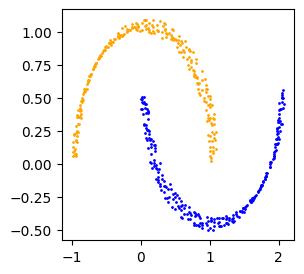

In [32]:
from torchdyn.core import NeuralODE
from torchdyn.datasets import *
from torchdyn import *

d = ToyDataset()
X, yn = d.generate(n_samples=512, noise=1e-1, dataset_type='moons') #this is a test dataset for a binary classification problem
#X is a tensor of size [512,2] it contains the cordinates of the points
#yn contains the classification of the points as to which "moon" they belong to



import matplotlib.pyplot as plt

colors = ['orange', 'blue']
fig = plt.figure(figsize=(3,3))
ax = fig.add_subplot(111)
for i in range(len(X)):
    ax.scatter(X[i,0], X[i,1], s=1, color=colors[yn[i].int()])
    
import torch
import torch.utils.data as data
device = torch.device("cuda") 

X_train = torch.Tensor(X).to(device) #parsing the points to device
y_train = torch.LongTensor(yn.long()).to(device) #parsing the labels to the device
train = data.TensorDataset(X_train, y_train) #a tensorDataset is just a class to represent the tensors as a dataset
trainloader = data.DataLoader(train, batch_size=len(X), shuffle=True) #dataloader is a loader for the TensorDataset we have made. The batch wize is the number of samples used in one training iteration


import torch.nn as nn
import pytorch_lightning as pl

class Learner(pl.LightningModule):
    def __init__(self, t_span:torch.Tensor, model:nn.Module):
        super().__init__()
        self.model, self.t_span = model, t_span

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        x, y = batch
        t_eval, y_hat = self.model(x, t_span)
        y_hat = y_hat[-1] # select last point of solution trajectory
        loss = nn.CrossEntropyLoss()(y_hat, y)
        return {'loss': loss}

    def configure_optimizers(self):
        return torch.optim.Adam(self.model.parameters(), lr=0.01)

    def train_dataloader(self):
        return trainloader
    
f = nn.Sequential(
        nn.Linear(2, 16),
        nn.Tanh(),
        nn.Linear(16, 2)
    )
t_span = torch.linspace(0, 1, 5)

model = NeuralODE(f, sensitivity='adjoint', solver='dopri5').to(device)

t_span = torch.linspace(0,1,100)
t_eval, trajectory = model(X_train, t_span)

learn = Learner(t_span, model)
trainer = pl.Trainer(min_epochs=10, max_epochs=100)
trainer.fit(learn)

t_eval, trajectory = model(X_train, t_span)
trajectory = trajectory.detach().cuda()

One pair of (X,y) looks like:
- d = 3 # number of dimensions
- N # number of objects
- X: N x (2 * d + 1) # positions, velocities, mass
- y: N x d # accelerations

A few changes and experiments have been made to this. 
- the batch size has changed
- there are only 2 visiable bodies
- it now iterates through 100 * dt
- X: (N x (2*d+1)) # positions, velocities, mass
- y: (N x (2*d+1)) # velocities, accelerations, mass
	- velocities is used as it is derivative of positions
	- accelerations is used as it is the deriviates of velocities

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.integrate import solve_ivp

batch_size = 256
visible = 10
hidden = 0
N = visible + hidden
d = 3

scale_exp = 5

pos = torch.exp(scale_exp * torch.rand(batch_size, N, d)) #creating positions using torch.rand in 3d array and scaling into log space
# make it centered at 0
pos -= pos.mean(axis=1, keepdim = True) # - the mean from all postions to center around mean
#mainly for hidden objerct 

vel = torch.exp(scale_exp * torch.rand(batch_size, N, d)) #creating velocities in the same way to positions in the x,y,z direction

# assign fixed positions, velocities??? (this shouldn't matter for now) to hidden objects (this only works for one that is put in the center for now)
#pos[:,:hidden,:] *= 0 #getting hidden value at the 1st spot and fixing the position
#vel[:,:hidden,:] *= 0

m = torch.rand(1, N, 1) #creating a random 1.n.1 matrix as the mass n is = to 11 here so it is a 1.11.1 matrix
# hidden mass:
#m[0,:hidden,0] = m[0,:hidden,0] * 0 + 1 #setting up the hidden mas to be = to the value of 1

m = torch.exp(scale_exp * m) #setting the mass into logspace  m is 1,n,1
m = m.expand(batch_size,-1,-1) #expanding the mass matrix to be the size of the position and velocity tensor but is 32768x11x1 and velocity and position tensors are 32768x11x3


dt = 0.01 #time delta
g = 0.5 #gravitation constant

mtest = m.unsqueeze(2)

ms = m.unsqueeze(2).expand(-1,-1,N,-1) #unsqueezing so the will be (32786x11x1x1) with the 1 in the second postion being the added dimention and then expanding this dimention to be size 11 so final size is (32786x11x11x1)
m1 = ms #settting m1 = to these values
m2 = ms.transpose(1,2) #setting m2 = to these values but transposed 

X_list = []
y_list = []

posNmp = pos.numpy()

posNmpC = posNmp.copy()

posNmpC = posNmpC[0,:,:]

#print(posNmpC)

x_vals = posNmpC[:,0]
y_vals = posNmpC[:,1]
z_vals = posNmpC[:,2]

# fig = plt.figure(figsize=(12,12))


# ax = fig.add_subplot(projection='3d')

# ax.plot3D(x_vals,y_vals,z_vals)

# ax.scatter(x_vals,y_vals,z_vals,c=z_vals)

plt.show()

for _ in range(100):
    xs = pos.unsqueeze(2).expand(-1,-1,N,-1) #creating tensor from the positions that is the same size as the mass (ms) tensor 32786x11x11x1
    x1 = xs
    x2 = xs.transpose(1,2) #same flow as the mass tensor seperation

    delta_x = x1 - x2 #finding the distance between each pair of x1 x2 cordinates
    delta_x_norm = (delta_x ** 2).sum(dim=-1, keepdim=True)**0.5 + 1e-9 #normalizing the distance values by squaring then summing the values. Summing using dim -1 dimentions and keeping the dims the same in the output
    #This is all then square rooted and +1e-9 is added to stop 0 errors
    forces = -1 * g * m1 * m2 / delta_x_norm ** 2 #This then calculates a base force using hte place holder values and our normalized distance between the 2 bodies and the mass. Is a scalar as no direction is found due to the squaring in the previouse normalization

    # the delta_x_norms were offset by a small number to avoid numeric problems
    # this is fine, when multiplying by delta_x, the self-self terms are zeroed out
    force_vectors = forces * delta_x / delta_x_norm  #dividing the distance by the normalized distance and * force to give a vector
    a = force_vectors.sum(dim=2) / m1[:,:,0,:] # creating a variable that contains the force vectors summed together devided by a mass so the acceleration is calculated
    print("positions size: ",pos.size())
    print("mass size: ",m.size())
    print("velocity size: ",vel.size())
    X_list.append(torch.cat((pos, vel, m), dim=-1)) #concatendating the positions velocities masses and -1 invert matrix dimentions
    print("acellerations size: ",a.size())
    print("mass size: ",m.size())
    print("velocity size: ",vel.size())
    print("acellerations dim: ",a.dim())
    print("mass dim: ",m.dim())
    print("velocity dim: ",vel.dim())
    y_list.append(torch.cat((vel,a,m),dim=-1)) #adding the calculated acceleration into the tensor

    # simple 1 step - could use a more intelligent integrator here.
    vel += a * dt #re calculating velocity tensor so for seteping updates position and velocity for the acceleration
    pos += vel * dt #re calculating position tensor
    m = m

X = torch.cat(X_list) # setting X_list to be X
y = torch.cat(y_list) # setting y_list ot be y


print("X final size: ", X.size())
print("Y final size: ", y.size())
#try non wrapped data without data loader

#print(X)
# # remove hidden objects
# X = X[:,hidden:,:] 
# y = y[:,hidden:,:]

# xNmp = X.numpy().copy()


# xPos = xNmp[:,:,0:3]





# x_vals = xPos[:,:,0]
# y_vals = xPos[:,:,1]
# z_vals = xPos[:,:,2]

# trainPos = [x_vals,y_vals,z_vals]
# sampPos = []

# for i in range(0,len(trainPos),10):
#     xVal = trainPos[i]

# trainPos = torch.Tensor(trainPos)

y += 0.1 * torch.randn(y.shape) * y.mean()


positions size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations dim:  3
mass dim:  3
velocity dim:  3
positions size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations dim:  3
mass dim:  3
velocity dim:  3
positions size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 10, 3])
acellerations dim:  3
mass dim:  3
velocity dim:  3
positions size:  torch.Size([256, 10, 3])
mass size:  torch.Size([256, 10, 1])
velocity size:  torch.Size([256, 

In [3]:
class BaseModule(pl.LightningModule):
    def __init__(self):
        super(BaseModule, self).__init__()
        self.input_size = 3 # r, m1, m2
        self.output_size = 1
        self.loss = F.mse_loss # torch.log(F.mrse_loss) + angle loss
        self.lr = 1e-3
        self.wd = 1e-5
        # relative mean weighted error - this wasn't helpful at all
        # self.loss = lambda y_hat, y: ((y_hat - y).abs() / (y.abs() + 1e-8)).mean()
        
        self.my_loggers = {
            'r_exp': lambda s: s.formula.weight[0][0].item(),
            'm1_exp': lambda s: s.formula.weight[0][1].item(),
            'm2_exp': lambda s: s.formula.weight[0][2].item()
        }
        

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('train_loss', loss.item(), on_epoch=True, on_step=False)

        # log learning terms
        for name, fx in self.my_loggers.items():
            self.log(name, fx(self), on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('validation_loss', loss.item(), on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr, weight_decay=self.wd)
        return optimizer 


class GnnLogLinearModelODE(BaseModule):
    def __init__(self,t_span:torch.Tensor,model:nn.Module):
        super(GnnLogLinearModelODE, self).__init__()
        self.formula=model
        self.t_span=t_span #trying by parsing the model and the learning in here
        print(self.input_size,self.output_size)

    def forward(self, X):#putting result of learnable layer into graph neural net very similar to the data generation
        N = X.shape[1]
        #UNFLATTEN 
        print("N is: ",N)
        print("X size is: ",X.size())#[3200,2,7]
        xs = X[:,:,:d].unsqueeze(2).expand(-1,-1,N,-1) #[100,10,10,3]
        ms = X[:,:,-1:].unsqueeze(2).expand(-1,-1,N,-1) #[100,10,10,1]
        vel = X[:,:,d:d+3].unsqueeze(2).expand(-1,-1,N,-1) #slicing the middle tensor for the velocities  #[100,10,10,3]
        ###TAKE OUT VELOCITIES
        #print("postitions: ",xs.size())
        #print("Masses: ",ms.size())
        #print("velocities: ",vel.size())
        masses_copy = ms
        x1 = xs
        x2 = xs.transpose(1,2)
        delta_x = x1 - x2
        delta_x_norm = (delta_x ** 2).sum(dim=-1, keepdim=True)**0.5 + 1e-9
        m1 = ms
        m2 = ms.transpose(1,2)
        
        #print("m1 shape: ",m1.size())

        #inp = torch.cat((delta_x_norm, m1, m2), dim=-1)
        
        inp = X

        inp_log = inp #removing log due to return from ODE being a tuple

        # one linear layer
        forces_log = self.formula(inp_log,self.t_span)
        y_hat = forces_log[-1] #last point in trajectory
        
        #print(y_hat)
        
        #print("yhat size: ",y_hat.size())

        #print(type(forces_log))
        #forces_log = np.asarray(forces_log)
        #print("shape of forces log: ",forces_log.shape())
        #forces_log = torch.numpy(forces_log)


        

        # the delta_x_norms were offset by a small number to avoid numeric problems
        # this is fine, when multiplying by delta_x, the self-self terms are zeroed out
        #Generate y that contains next shape
        # force_vectors = forces * delta_x / delta_x_norm
        
        # print("force_vectors shape: ",force_vectors.size())
        
        diff_factors = y_hat[-1,:,:,:]
        
        
        print("diff_factors shape",diff_factors.size())
        
        # #print("ms shape: ",ms.size())
        
        # masses_copy = masses_copy.unsqueeze(0).expand(100,-1,-1,-1,-1)
        
        # tempFV = force_vectors*-1
        
        # print("tempFV shape", tempFV.size())
        
        
        # print("force_vectors shape: ",force_vectors.size())
        # print("force_vectors dim: ",force_vectors.dim())
        # print("vel shape: ",force_vectors.size())
        # print("vel dim: ",force_vectors.dim())
        # print("masses_copy shape: ",masses_copy.size())
        # print("masses_copy dim: ",masses_copy.dim())
        
        # print(masses_copy)
        
        # xReturn = []

        # # later learn this directionality too (the -1)
        # #DIM = nObject*NDimentions (so e.g. for this one is 10*7)
        # xReturn = torch.cat((vel,force_vectors,masses_copy), dim=0)#trying to make the output look like y
        return diff_factors #/ m1[:,:,0,:] #still acceleration

In [130]:
# from torch.utils.data import DataLoader, Dataset, random_split
# from pytorch_lightning.callbacks.early_stopping import EarlyStopping
# from pytorch_lightning.loggers import TensorBoardLogger
# from torchdyn.core import NeuralODE

# for mult in [1]:

# 	train_set = list(zip(X, y))
# 	train_set_size = int(len(train_set) * 0.8)
# 	valid_set_size = len(train_set) - train_set_size
# 	train_set, valid_set = random_split(train_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))
	
# 	best_model = None
# 	best_score = 1e15
# 	times = 5
	
# 	f = nn.Sequential(
# 		nn.Linear(7, 16),
# 		nn.Tanh(),
# 		nn.Linear(16, 7)
# 	)
# 	t_span = torch.linspace(0, 1, 100)
# 	modelNODE = NeuralODE(f, sensitivity='adjoint', solver='dopri5')

# 	for _ in range(times):
# 		model=GnnLogLinearModelODE(t_span,modelNODE)
# 		#model = GnnLogLinearModelMult(mult=mult)
# 		#model = GnnLogLinearMassModelODE(hidden_size=mult)
# 		#model = GnnLogLinearMassModel(10)
# 		#model = GnnLogLinearMassModelODE(10)
# 		#model = GnnLogLinearHiddenMassModel(10, e=10, formula_given=False)
# 		X = torch.tensor(X)
# 		y_hat = model.forward(X)
# 		loss = model.loss(y_hat, y)
# 		if loss < best_score:
# 			print("loss = ",loss)
# 			best_score = loss
# 			best_model = model

 

Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.
3 1
N is:  2
X size is:  torch.Size([800, 2, 7])


C:\Users\Hugo Truran\AppData\Local\Temp\ipykernel_20772\2062406532.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X)


diff_factors shape torch.Size([800, 2, 7])
loss =  tensor(1035.8644, grad_fn=<MseLossBackward0>)
3 1
N is:  2
X size is:  torch.Size([800, 2, 7])
diff_factors shape torch.Size([800, 2, 7])
3 1
N is:  2
X size is:  torch.Size([800, 2, 7])
diff_factors shape torch.Size([800, 2, 7])
3 1
N is:  2
X size is:  torch.Size([800, 2, 7])
diff_factors shape torch.Size([800, 2, 7])
3 1
N is:  2
X size is:  torch.Size([800, 2, 7])
diff_factors shape torch.Size([800, 2, 7])


In [4]:
class BaseModule(pl.LightningModule):
    def __init__(self):
        super(BaseModule, self).__init__()
        self.input_size = 3 # r, m1, m2
        self.output_size = 1
        self.loss = F.mse_loss # torch.log(F.mrse_loss) + angle loss
        self.lr = 1e-3
        self.wd = 1e-5
        # relative mean weighted error - this wasn't helpful at all
        # self.loss = lambda y_hat, y: ((y_hat - y).abs() / (y.abs() + 1e-8)).mean()
        
        self.my_loggers = {
            'r_exp': lambda s: s.formula.weight[0][0].item(),
            'm1_exp': lambda s: s.formula.weight[0][1].item(),
            'm2_exp': lambda s: s.formula.weight[0][2].item()
        }
        

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('train_loss', loss.item(), on_epoch=True, on_step=False)

        # log learning terms
        for name, fx in self.my_loggers.items():
            self.log(name, fx(self), on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('validation_loss', loss.item(), on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer 


class GnnLogLinearModelODE(pl.LightningModule):
    def __init__(self,t_span:torch.Tensor,model:nn.Module):
        super().__init__()
        self.formula=model
        self.t_span=t_span #trying by parsing the model and the learning in here
        self.input_size = 3 # r, m1, m2
        self.output_size = 1
        self.loss = F.mse_loss #
        self.lr = 1e-3
        
        #print(self.input_size,self.output_size)

    def forward(self, X):#putting result of learnable layer into graph neural net very similar to the data generation
        N = X.shape[1]
        #UNFLATTEN 
        print("N is: ",N)
        print("X size is: ",X.size())#[3200,2,7]
        xs = X[:,:,:d].unsqueeze(2).expand(-1,-1,N,-1) #[100,10,10,3]
        ms = X[:,:,-1:].unsqueeze(2).expand(-1,-1,N,-1) #[100,10,10,1]
        vel = X[:,:,d:d+3].unsqueeze(2).expand(-1,-1,N,-1) #slicing the middle tensor for the velocities  #[100,10,10,3]
        ###TAKE OUT VELOCITIES
        #print("postitions: ",xs.size())
        #print("Masses: ",ms.size())
        #print("velocities: ",vel.size())
        masses_copy = ms
        x1 = xs
        x2 = xs.transpose(1,2)
        delta_x = x1 - x2
        delta_x_norm = (delta_x ** 2).sum(dim=-1, keepdim=True)**0.5 + 1e-9
        m1 = ms
        m2 = ms.transpose(1,2)
        
        #print("m1 shape: ",m1.size())

        #inp = torch.cat((delta_x_norm, m1, m2), dim=-1)
        
        inp = X

        inp_log = inp #removing log due to return from ODE being a tuple

        # one linear layer
        forces_log = self.formula(inp_log,self.t_span)
        y_hat = forces_log[-1] #last point in trajectory
        
        #print(y_hat)
        
        #print("yhat size: ",y_hat.size())

        #print(type(forces_log))
        #forces_log = np.asarray(forces_log)
        #print("shape of forces log: ",forces_log.shape())
        #forces_log = torch.numpy(forces_log)

        # the delta_x_norms were offset by a small number to avoid numeric problems
        # this is fine, when multiplying by delta_x, the self-self terms are zeroed out
        #Generate y that contains next shape
        # force_vectors = forces * delta_x / delta_x_norm
        
        # print("force_vectors shape: ",force_vectors.size())
        
        diff_factors = y_hat[-1,:,:,:]
        
        
        print("diff_factors shape",diff_factors.size())
        
        # #print("ms shape: ",ms.size())
        
        # masses_copy = masses_copy.unsqueeze(0).expand(100,-1,-1,-1,-1)
        
        # tempFV = force_vectors*-1
        
        # print("tempFV shape", tempFV.size())
        
        
        # print("force_vectors shape: ",force_vectors.size())
        # print("force_vectors dim: ",force_vectors.dim())
        # print("vel shape: ",force_vectors.size())
        # print("vel dim: ",force_vectors.dim())
        # print("masses_copy shape: ",masses_copy.size())
        # print("masses_copy dim: ",masses_copy.dim())
        
        # print(masses_copy)
        
        # xReturn = []

        # # later learn this directionality too (the -1)
        # #DIM = nObject*NDimentions (so e.g. for this one is 10*7)
        # xReturn = torch.cat((vel,force_vectors,masses_copy), dim=0)#trying to make the output look like y
        return diff_factors #/ m1[:,:,0,:] #still acceleration
    
    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('train_loss', loss.item(), on_epoch=True, on_step=False)

        #log learning terms
        # for name, fx in self.my_loggers.items():
        #     self.log(name, fx(self), on_epoch=True, on_step=False)

        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        loss = self.loss(y_hat, y)
        self.log('validation_loss', loss.item(), on_epoch=True, on_step=False)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        return optimizer 

In [5]:
from torch.utils.data import DataLoader, Dataset, random_split
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger
from torchdyn.core import NeuralODE

for mult in [1]:

	train_set = list(zip(X, y))
	train_set_size = int(len(train_set) * 0.8)
	valid_set_size = len(train_set) - train_set_size
	train_set, valid_set = random_split(train_set, [train_set_size, valid_set_size], generator=torch.Generator().manual_seed(42))
	
	best_model = None
	best_score = 1e15
	times = 1
	
	f = nn.Sequential(
		nn.Linear(7, 16),
		nn.Tanh(),
		nn.Linear(16, 7)
	)
	t_span = torch.linspace(0, 1, 100)
	modelNODE = NeuralODE(f, sensitivity='adjoint', solver='dopri5')

	# for _ in range(times):
	# 	model=GnnLogLinearModelODE(t_span,modelNODE)
	# 	#model = GnnLogLinearModelMult(mult=mult)
	# 	#model = GnnLogLinearMassModelODE(hidden_size=mult)
	# 	#model = GnnLogLinearMassModel(10)
	# 	#model = GnnLogLinearMassModelODE(10)
	# 	#model = GnnLogLinearHiddenMassModel(10, e=10, formula_given=False)
	# 	X = torch.tensor(X)
	# 	y_hat = model.forward(X)
	# 	loss = model.loss(y_hat, y)
	# 	if loss < best_score:
	# 		print(loss)
	# 		best_score = loss
	# 		best_model = model
   
	model=GnnLogLinearModelODE(t_span,modelNODE)
   
	early_stop_callback = EarlyStopping(monitor="validation_loss", patience=30, verbose=False, mode="min")

	train_set = DataLoader(train_set, shuffle=False, batch_size=100)
	valid_set = DataLoader(valid_set, shuffle=False, batch_size=100)
	logger = TensorBoardLogger("lightning_logs", name=f'ODETesting') # _masses, hidden_multiple
	# train with both splits
	trainer = pl.Trainer(gpus=1, max_epochs=10000,
							logger=logger,
							enable_progress_bar=True)

	trainer.fit(model, train_set , valid_set)

c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\accelerator_connector.py:447: LightningDeprecationWarning: Setting `Trainer(gpus=1)` is deprecated in v1.7 and will be removed in v2.0. Please use `Trainer(accelerator='gpu', devices=1)` instead.
  rank_zero_deprecation(
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Your vector field callable (nn.Module) should have both time `t` and state `x` as arguments, we've wrapped it for you.


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type      | Params
--------------------------------------
0 | formula | NeuralODE | 247   
--------------------------------------
247       Trainable params
0         Non-trainable params
247       Total params
0.001     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, val_dataloader 0, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])


c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:236: PossibleUserWarning: The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 8 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

Validation: 0it [00:00, ?it/s]

N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])
N is:  10
X size is:  torch.Size([100, 10, 7])
diff_factors shape torch.Size([100, 10, 7])

c:\Users\Hugo Truran\AppData\Local\Programs\Python\Python310\lib\site-packages\pytorch_lightning\trainer\trainer.py:653: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")
